In [10]:
import json
import plotly.express as px
import pandas as pd
import scipy.stats as stats
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re

F-statistic: 17.10270957631583, P-value: 9.475925959175811e-24
Performing Tukey HSD test to find which groups are significantly different...
           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------
       group_four group_one_because    -0.38  0.001 -0.5829 -0.1771   True
       group_four  group_one_sothat    -0.29  0.001 -0.4929 -0.0871   True
       group_four      group_one_to    -0.19 0.0874 -0.3929  0.0129  False
       group_four    group_original     0.04    0.9 -0.1629  0.2429  False
       group_four         group_six     0.27 0.0013  0.0671  0.4729   True
       group_four       group_three    -0.05    0.9 -0.2529  0.1529  False
       group_four  group_two_sothat  -0.1192 0.6811 -0.3295  0.0911  False
       group_four      group_two_to  -0.0782    0.9 -0.2878  0.1315  False
group_one_because  group_one_sotha

/pool/bwjiang/anaconda3/lib/python3.8/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


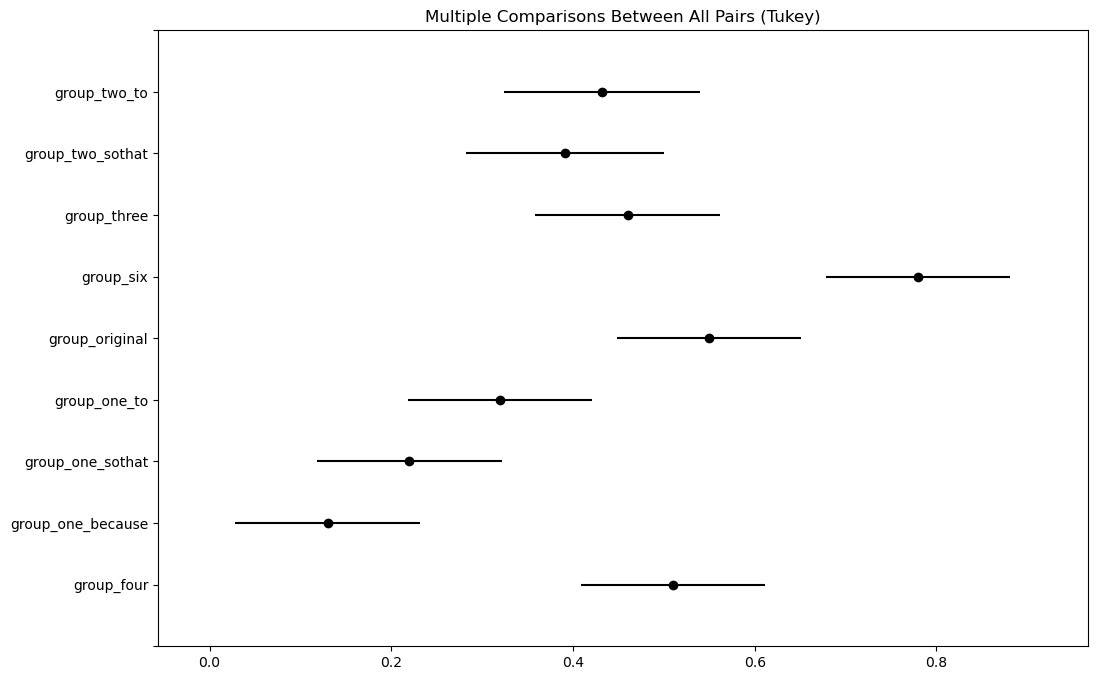

In [16]:
# H1: anova
def get_binary_results(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    binary_results = []
    for key, value in data.items():
        if isinstance(value, dict):
            init_grades = value.get("init_grades", [])
            if init_grades == ["[Correct]"]:
                binary_results.append(1)
            elif init_grades == ["[Incorrect]"]:
                binary_results.append(0)
    return binary_results

# Dictionary to store groups
groups = {}

# Suffixes for filenames
suffixes = ['one_because','one_sothat','one_to','one_because','two_sothat','two_to','three','four','six']

# Populate groups dictionary
for i in suffixes:
    file_path = f'outputs/gpt-4-turbo/responses_baseline_synthetic_dataset_linda_variant_{i}_gold.json'
    groups[f'group_{i}'] = get_binary_results(file_path)

groups[f'group_original'] = get_binary_results(f'outputs/gpt-4-turbo/responses_baseline_synthetic_dataset_linda_original_gold.json')

# Prepare data for ANOVA and Tukey HSD test
labels = []
data = []

for group_name, results in groups.items():
    labels.extend([group_name] * len(results))
    data.extend(results)

# Convert data to numpy array for compatibility with statsmodels functions
data = np.array(data)
labels = np.array(labels)

# Perform ANOVA test
f_statistic, p_value = stats.f_oneway(*groups.values())

print(f"F-statistic: {f_statistic}, P-value: {p_value}")

# Convert group_names to a pandas Series
group_series = pd.Series(labels)

# Define the order of groups for the Tukey HSD plot
order = ['group_original', 'group_one_because', 'group_one_sothat', 'group_one_to', 
         'group_two_sothat', 'group_two_to', 'group_three', 'group_four', 'group_six']

# Convert labels to a pandas Categorical type with the specified order
ordered_labels = pd.Categorical(labels, categories=order, ordered=True)

# Perform Tukey HSD test if ANOVA is significant
if p_value < 0.05:
    print("Performing Tukey HSD test to find which groups are significantly different...")
    tukey_results = pairwise_tukeyhsd(endog=data, groups=ordered_labels, alpha=0.05)
    print(tukey_results)
    # Plot the results
    fig = tukey_results.plot_simultaneous()
    fig.set_figwidth(12)
    fig.set_figheight(8)
    plt.show()
else:
    print("No significant difference between the group means. No further testing is required.")

In [13]:
# Function to extract binary results based on init_grades
def get_binary_results(init_grades):
    if "[Correct]" in init_grades:
        return 1
    elif "[Incorrect]" in init_grades:
        return 0
    else:
        return None

# Define the directory containing the JSON files
directory = '/pool/bwjiang/llm_fallacy/outputs/gpt-4-turbo/'

# Use glob to find all JSON files in the directory
files = glob.glob(f'{directory}*.json')

# Prepare a list for DataFrame creation
results = []

# Process each file
for file_path in files:
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    # Extract parts from the filename
    filename = file_path.split('/')[-1]
    
    # Adjusted regex to capture accurately between defined texts
    # Using non-greedy capture for the prompting_method and a more robust pattern
    match = re.search(r"responses_(.+)_synthetic.*linda_variant_(.+)_([^_]+)\.json", filename)
    if match:
        prompting_method, group, generation_mode = match.groups()

        print(f"Debugging filename: {filename}")
        print(f"Captured groups: Prompting method: {prompting_method}, Group: {group}, Generation mode: {generation_mode}")

        for key, value in data.items():
            if isinstance(value, dict):  # Check if it's a dictionary
                binary_result = get_binary_results(value.get("init_grades", []))
                # Append the results
                results.append({
                    "binary_result": binary_result,
                    "group": group,
                    "prompting_method": prompting_method,
                    "generation_mode": generation_mode
                })

# Create DataFrame
df = pd.DataFrame(results)

# Display the DataFrame
print(df.head())

# drop na
df = df.dropna(subset=['binary_result'])


Debugging filename: responses_os_bob_synthetic_dataset_linda_variant_three_gold.json
Captured groups: Prompting method: os_bob, Group: three, Generation mode: gold
Debugging filename: responses_os_bob_cot_synthetic_dataset_linda_variant_three_gold.json
Captured groups: Prompting method: os_bob_cot, Group: three, Generation mode: gold
Debugging filename: responses_control_os_cot_synthetic_dataset_linda_variant_six_gold.json
Captured groups: Prompting method: control_os_cot, Group: six, Generation mode: gold
Debugging filename: responses_control_zs_cot_synthetic_dataset_linda_variant_one_sothat_gold.json
Captured groups: Prompting method: control_zs_cot, Group: one_sothat, Generation mode: gold
Debugging filename: responses_zs_cot_synthetic_dataset_linda_variant_one_sothat_gold.json
Captured groups: Prompting method: zs_cot, Group: one_sothat, Generation mode: gold
Debugging filename: responses_os_cot_synthetic_dataset_linda_variant_one_to_gold.json
Captured groups: Prompting method: os_

In [ ]:
# Fixed effect model
